In [9]:
import pandas as pd
import json
import copy
from cargurus_model import *
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import numpy as np

from matplotlib import pyplot as plt

from torch.utils.data import DataLoader

from util_scraper import *

In [10]:
torch.manual_seed(50)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
pred = 'price'
ind = 'car_year'
title = 'car_title'

In [13]:
df = pd.read_csv(nonoutlier_path, dtype=np.float32, encoding = "UTF-8")
# print(df.dtypes)

with open(cats_path) as file:
    cats_to_labels = json.load(file)

with open(norm_path) as file:
    cats_to_norm = json.load(file)


In [14]:
model = CarGurus_Model(len(df.columns)-1).to(device)
print(model.inner_model)

# model = CarGurus_Model(2).to(device)
# print(model.inner_model)


Sequential(
  (fc1): Linear(in_features=14, out_features=7, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=7, out_features=3, bias=True)
  (act2): ReLU()
  (fc3): Linear(in_features=3, out_features=1, bias=True)
)


## Train Model

In [15]:
epochs = 10
lr = 5e-3
test_split = 0.2


criterion = torch.nn.MSELoss(reduction='sum')
# optimizer = torch.optim.SGD(model.inner_model.parameters(), lr=lr)
optimizer = torch.optim.Adam(model.inner_model.parameters(), lr=lr)


In [16]:
train, test = train_test_split(df, test_size=test_split)

0.621490478515625 0.7341253757476807
0.5012725591659546 0.534481406211853
0.40554919838905334 0.4625745117664337
0.16713964939117432 0.12603303790092468
0.34517037868499756 0.2610224485397339
0.1278655081987381 0.12638504803180695
0.34525981545448303 0.34716588258743286
0.4477178752422333 0.47548702359199524
0.34550222754478455 0.34071362018585205
0.4506944417953491 0.4575583040714264
0.1498846709728241 0.1156766265630722
0.08776453137397766 0.11088843643665314
0.4495512545108795 0.437765508890152
0.6292781829833984 0.7002120018005371
0.15655185282230377 0.10798431932926178
0.23005451261997223 0.21200047433376312
0.6264649629592896 0.5039401650428772
0.6705914735794067 0.6736549735069275
0.23913654685020447 0.16075442731380463
0.34411191940307617 0.3726029098033905
0.5710304975509644 0.6155446171760559
0.48396843671798706 0.5634705424308777
0.4055684208869934 0.4249129891395569
0.6077595949172974 0.684567391872406
0.9102332592010498 0.8656986355781555
0.34411799907684326 0.325725018978

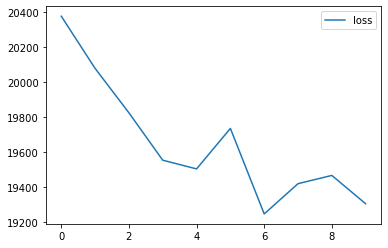

In [18]:

####### TRAIN MODEL #######
###########################
model.inner_model.train(True)
losses = []
for epoch in range(epochs):
    epoch_loss = 0
    
    train = shuffle(train)
    
    train_X = copy.deepcopy(train)
    # train_X = train[[pred,'car_year']]
    # train_X = train[pred]
    train_y = train[pred]
    del train_X[pred]
    
    for row_X, row_y in zip(train_X.iterrows(), train_y):
        # model.half()
        # print(row_X[1].tolist(), row_y)
        # break
        
        X = torch.tensor(row_X[1], dtype=torch.float32, requires_grad=True).to(device=device)
        # X = torch.tensor([row_X], dtype=torch.float32).to(device=device)
        y = torch.tensor([row_y], dtype=torch.float32).to(device=device)
        
        # Forward pass: Compute predicted y by passing x to the model
        y_pred = model(X)
        if epoch == epochs-1:
            print(y_pred.item(), y.item())
        
        # Compute and print loss
        loss = criterion(y_pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        # model.float()
        # print(X.grad)
        
        optimizer.step()
        
        epoch_loss += loss.detach()
    
    
    losses.append(math.sqrt(epoch_loss.item()/df[ind].size) * cats_to_norm[pred])

model.inner_model.train(False)

plt.plot(losses, label = "loss")
plt.legend()
plt.savefig(f"data/model/losses_up_to_epoch_{epoch}.jpg", bbox_inches='tight')


In [ ]:
####### TEST MODEL #######
##########################

test_X = copy.deepcopy(train)
test_y = test_X[pred]
del test_X[pred]

test_losses = 0
for row_X, row_y in zip(test_X.iterrows(), test_y):
    # print(row_X)
    # print(row_y)
    X = torch.tensor([int(val) for val in row_X[1].tolist()], dtype=torch.float32)
    
    y_pred = model(X)
    # print(y_pred)
    
    loss = criterion(y_pred, y)
    test_losses += loss.detach()
    
print(math.sqrt(test_losses/test_X.shape[0]) * cats_to_norm[pred])
    
    

In [ ]:
# print(list(model.inner_model.parameters()))